Take daily means and good structuring from some files. Goes together with readme file.

In [2]:
import numpy as np
import os
import glob
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
FONTSIZE = 14
plt.rcParams.update({
    'font.size': FONTSIZE,          
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'figure.titlesize': FONTSIZE
})

file_savedir = '/home/ccorbella/scratch2_symboliclink/files/station_timeseries_preprocessed/'
file_readdir = '/home/ccorbella/scratch2_symboliclink/files/station_timeseries_orig/'

# Define a function to categorize hours into morning, midday, and evening
def tod(hour):
    if hour < 10:
        return "morning"
    elif 10 <= hour < 16:
        return "midday"
    else:
        return "evening"
    
def make_date_col(df):
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']], errors='coerce')
    return df

# Define weights for each hour
default_weights = {"morning": 0.3, "midday": 0.5, "evening": 0.2}

# select dates of interest
def select_dates(df):
    df = df[df['Date'] <= '1850-12-31']
    df = df[df['Date'] >= '1806-01-01']
    df.index -= df.index[0] # reset indices
    return df  


## Bologna


In [2]:
bologna = pd.read_csv(f'{file_readdir}TG_SOUID100862.txt', sep=',', header=13)
bologna = bologna.replace(-9999, np.NaN)
bologna = bologna.drop(columns=' SOUID')
bologna.rename({'    DATE': 'Date', '   TG': 'TG', ' Q_TG':'Q_TG'}, inplace=True, axis='columns')
bologna['Date'] = pd.to_datetime(bologna['Date'], format='ISO8601')
bologna.loc[bologna['TG'].notna() & bologna['Q_TG']==1] # check how many suspect cells (Q_TG==1) and how many missing cells (Q_TG==9) are not empty

bologna = select_dates(bologna)

# convert units
bologna['TMP2m'] = bologna['TG']*.1
bologna[['Date', 'TMP2m']].to_csv(f'{file_savedir}Bologna_TMP2m.csv')

## Cádiz

We have 29244-13=29231 days with values in Peter's data from IMPROVE. Now let's count how many we have from the raw. We have no duplicates in dataset, and we have 29231 non-NaNs. Yay! it's the same. It looks like `CSF-TP801-819.txt` is just a small subset of `CSF-TP786-879.txt`.

In [3]:
cadiz1 = pd.read_csv(f'{file_readdir}CSF-TP786-879.txt', sep="\t", header=None)
cadiz2 = pd.read_csv(f'{file_readdir}CSF-TP801-819.txt', sep="\t", header=None)

cadiz1.columns = ['Date', 'Tmin', 'Tmax', 'TMP2m', 'PRMSL']
cadiz2.columns = cadiz1.columns

cadiz1 = cadiz1.replace(-999.0, np.NaN)
cadiz2 = cadiz2.replace(-999.0, np.NaN)

# drop if all NaNs
cadiz1 = cadiz1.dropna(subset=['TMP2m', 'PRMSL'], how='all')
cadiz2 = cadiz2.dropna(subset=['TMP2m', 'PRMSL'], how='all')

cadiz1['Date'] = pd.to_datetime(cadiz1['Date'], format="%d/%m/%Y")
cadiz2['Date'] = pd.to_datetime(cadiz2['Date'], format="%d/%m/%Y")
cadiz1 = select_dates(cadiz1)
cadiz2 = select_dates(cadiz2)
print(np.sum(cadiz2['TMP2m']!= cadiz1[:3323]['TMP2m']))

cadiz1[['Date', 'TMP2m']].to_csv(f'{file_savedir}Cadiz_TMP2m.csv')
cadiz1[['Date', 'PRMSL']].to_csv(f'{file_savedir}Cadiz_PRMSL.csv')

0


## CET
https://www.metoffice.gov.uk/hadobs/hadcet/data/download.html

In [73]:
df = pd.read_csv(f'{file_readdir}CET_ta.txt', sep='\s+', skiprows=0, header=1)

df = select_dates(df)
df = df.rename(columns={'Value':'TMP2m'})
df.to_csv(f'{file_savedir}CET_TMP2m.csv')

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3901398/4282479213.py:1: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(f'{file_readdir}CET_ta.txt', sep='\s+', skiprows=0, header=1)


check if CET from downloaded page is the same as CET from Peter.

In [75]:
cet_peter = pd.read_csv('/home/ccorbella/scratch2_symboliclink/files/1807_USBstick/not_to_use/CET_ta_daily.tsv',
                        sep='\t',skiprows=12)
make_date_col(cet_peter)

df_1807 = df[df['Date']>='1807-01-01']
df_1807 = df_1807[df_1807['Date']<='1807-12-31']
cet_peter['Value'] = pd.to_numeric(cet_peter['Value'])
df_1807['TMP2m']   = pd.to_numeric(df_1807['TMP2m'], errors='coerce')

diff = (df_1807['TMP2m'].astype(float).reset_index(drop=True) - 
        cet_peter['Value'].astype(float).reset_index(drop=True))
np.sum(diff!=0)
# yes they are the same

0

## Haarlem
### Pressure

In [26]:
df = pd.read_csv(f'{file_readdir}/KNMI/KNMI_KNMI-44_Haarlem_17881101-18401231_p.tsv',sep='\t',header=12)
make_date_col(df)
df = select_dates(df)
df['Hour'] = pd.to_numeric(df['Hour'], errors='coerce')
df['Time_of_Day'] = df['Hour'].apply(tod)
valid_days = df.groupby('Date')['Time_of_Day'].nunique()
unvalid_dates = valid_days[valid_days!=3].index 
valid_dates   = valid_days[valid_days==3].index # select only dates w 3 obs
df_lt3 = df[df['Date'].isin(unvalid_dates)]

df = df[df['Date'].isin(valid_dates)]

In [27]:
# display days with unvalid periods
df_lt3

,Year,Month,Day,Hour,Minute,Period,Value,Meta,Date,Time_of_Day
16032,1820,8,19,7,41,0,1002.4,orig=29070inHg(e-2)|orig.time=0800,1820-08-19,morning
16033,1820,8,19,12,41,0,1001.7,orig=29063inHg(e-2)|orig.time=1300,1820-08-19,midday


In [28]:
df_p = df.groupby("Date").agg(
    PRMSL=("Value", "mean"),
).reset_index()

df_p.to_csv(f'{file_savedir}Haarlem_PRMSL.csv')

### Temperature

In [29]:
df = pd.read_csv(f'{file_readdir}/KNMI/KNMI_KNMI-44_Haarlem_17881101-18401231_ta_daily.tsv',sep='\t',header=12)
make_date_col(df)
df = select_dates(df)
df = df.rename(columns={'Value':'TMP2m'})
df[['Date','TMP2m']].to_csv(f'{file_savedir}Haarlem_TMP2m.csv')

## London


In [4]:
londonA = pd.read_csv(f'{file_readdir}/London_11_17870101-18221231_mslp.tsv',sep='\t',header=12)
londonB = pd.read_csv(f'{file_readdir}/London_12_18230101-18411231_mslp.tsv',sep='\t',header=12)

london = pd.concat([londonA,londonB], ignore_index=True)
make_date_col(london)
london = select_dates(london)

london = london.groupby("Date").agg(
    PRMSL=("Value", "mean"),
).reset_index()
london.to_csv(f'{file_savedir}London_PRMSL.csv')

## Milan
We already had temperature from `PALAEO-RA_IMPROVE_Milan_17630101-18621231_ta`, which is the same as the third column of the raw file, and now I add pressure.

In [5]:
milan = pd.read_csv(f'{file_readdir}MI_TP763_862.txt', sep=r'\s+', header=None)

milan.columns = ['Date', 'Tmin', 'Tmax', 'ta', 'p']

milan = milan.replace(-999.0, np.NaN)

# drop if all NaNs
milan = milan.dropna(subset=['ta', 'p'], how='all')

milan['Date'] = pd.to_datetime(milan['Date'], format="%d/%m/%Y")
milan = milan.rename(columns={'p':'PRMSL'})
milan = select_dates(milan)

milan[['Date', 'PRMSL']].to_csv(f'{file_savedir}Milan_PRMSL.csv')

## Padova
Ja teníem pressure i temperature fins a 1809, ara s'ha d'allargar i per no tenir 2 series de la mateixa station les concatenejo i en faig una de sola, que la utilitzaré per reemplaçar la de la carpeta USB stick Peter.

In [6]:
padova1 = pd.read_csv(f'{file_readdir}PD_PT766_809.txt', sep=r'\s+', header=None)
padova2 = pd.read_csv(f'{file_readdir}PD_PT810_853.txt', sep=r'\s+', header=None)

padova1.columns = ['Date', 'Tmin', 'Tmax', 'TMP2m', 'PRMSL']
padova2.columns = padova1.columns

padova1 = padova1.replace(-999.0, np.NaN)
padova2 = padova2.replace(-999.0, np.NaN)

# drop if all NaNs
padova1 = padova1.dropna(subset=['TMP2m', 'PRMSL'], how='all')
padova2 = padova2.dropna(subset=['TMP2m', 'PRMSL'], how='all')

padova1['Date'] = pd.to_datetime(padova1['Date'], format="%d/%m/%Y")
padova2['Date'] = pd.to_datetime(padova2['Date'], format="%d/%m/%Y")

padova = pd.concat([padova1, padova2], ignore_index=True)
padova = select_dates(padova)

padova[['Date', 'TMP2m']].to_csv(f'{file_savedir}Padova_TMP2m.csv')
padova[['Date', 'PRMSL']].to_csv(f'{file_savedir}Padova_PRMSL.csv')


## Paris
### Pressure

In [7]:
paris = pd.read_csv('/home/ccorbella/scratch2_symboliclink/files/station_timeseries_orig/Paris_4_17850101-18720615_mslp.tsv',sep='\t',header=12)
make_date_col(paris)
paris = paris.rename(columns={'Value':'PRMSL'})

paris = select_dates(paris)
paris[['Date','PRMSL']].to_csv(f'{file_savedir}Paris_PRMSL.csv')

### Temperature

In [41]:
paris_ta = pd.read_csv(f'{file_readdir}paris_Tjour.txt',
                       delimiter='\t')
paris_ta = paris_ta.iloc[:,:6]
paris_ta = paris_ta.rename(columns=lambda x:x.strip()) # removes whitespace
paris_ta = paris_ta.rename(columns={'Année':'Year',
                                    'Mois':'Month',
                                    'Jour':'Day',
                                    'TN':'Tmin',
                                    'TX':'Tmax',
                                    'T°C':'TMP2m'})

paris_ta['Tmax'] = pd.to_numeric(paris_ta['Tmax'],errors='coerce')
paris_ta['Tmin'] = pd.to_numeric(paris_ta['Tmin'],errors='coerce')
paris_ta['TMP2m'] = pd.to_numeric(paris_ta['TMP2m'],errors='coerce')
paris_ta['Tmean'] = (paris_ta['Tmin']+paris_ta['Tmax'])/2

paris_ta = paris_ta[paris_ta['Year']>1800]
paris_ta['Month'] = pd.to_numeric(paris_ta['Month'], downcast='integer', errors='coerce')
make_date_col(paris_ta)
paris_ta = select_dates(paris_ta)
paris_ta[['Date','TMP2m']].to_csv(f'{file_savedir}Paris_TMP2m.csv')
paris_ta

/tmp/ipykernel_1682990/766802865.py:1: DtypeWarning: Columns (3,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  paris_ta = pd.read_csv(f'{file_readdir}paris_Tjour.txt',


,Year,Month,Day,Tmin,Tmax,TMP2m,Tmean,Date
0,1806,1,1.0,5.8,10.4,8.1,8.10,1806-01-01
1,1806,1,2.0,1.0,6.3,3.6,3.65,1806-01-02
2,1806,1,3.0,-3.1,2.0,-0.6,-0.55,1806-01-03
3,1806,1,4.0,2.3,4.3,3.3,3.30,1806-01-04
4,1806,1,5.0,5.4,9.9,7.6,7.65,1806-01-05
...,...,...,...,...,...,...,...,...
16431,1850,12,27.0,1.3,3.6,2.5,2.45,1850-12-27
16432,1850,12,28.0,3.2,7.3,5.3,5.25,1850-12-28
16433,1850,12,29.0,3.5,7.5,5.5,5.50,1850-12-29
16434,1850,12,30.0,7.0,9.1,8.1,8.05,1850-12-30


## Prague

In [15]:
prague = pd.read_csv(f'{file_readdir}TG_STAID000027.txt', sep=',', header=14)
prague = prague.replace(-9999, np.NaN)
prague = prague.drop(columns=' SOUID')
prague.rename({'    DATE': 'Date', '   TG': 'TG', ' Q_TG':'Q_TG'}, inplace=True, axis='columns')
prague['Date'] = pd.to_datetime(prague['Date'], format='ISO8601')
prague.loc[prague['TG'].notna() & prague['Q_TG']==1] # check how many suspect cells (Q_TG==1) and how many missing cells (Q_TG==9) are not empty

,Date,TG,Q_TG
3711,1785-02-28,-213.0,1
30641,1858-11-23,-150.0,1
87607,2014-11-11,120.0,1
87608,2014-11-12,120.0,1
87609,2014-11-13,120.0,1
87610,2014-11-14,120.0,1
87611,2014-11-15,120.0,1


In [16]:
prague = select_dates(prague)

prague['TMP2m'] = prague['TG']*.1
prague[['Date','TMP2m']].to_csv(f'{file_savedir}Prague_TMP2m.csv')

## Stockholm
Same as Padova, without need for concatenating files. 

ATTENTION!! There's another file with explanations, `stockholm_SLP_1756_2012_hPa_hom.txt`, from `1807raw_andmore/database-web-stockholm-historical-weather-observations-1.0/database-web-stockholm-historical-weather-observations-1.0/air_pressure/`.

In [17]:
stockholm = pd.read_csv(f'{file_readdir}ST_TP756_880.txt', sep=r'\s+', header=None)

stockholm.columns = ['Date', 'TMP2m', 'PRMSL']

stockholm = stockholm.replace(-999.0, np.NaN)

# drop if all NaNs
stockholm = stockholm.dropna(subset=['TMP2m', 'PRMSL'], how='all')

stockholm['Date'] = pd.to_datetime(stockholm['Date'], format="%d/%m/%Y")
stockholm = select_dates(stockholm)

stockholm[['Date', 'PRMSL']].to_csv(f'{file_savedir}Stockholm_PRMSL.csv')
stockholm[['Date', 'TMP2m']].to_csv(f'{file_savedir}Stockholm_TMP2m.csv')

## Torino

In [18]:
df_ta = pd.read_csv(f'{file_readdir}torino_tmin-tmax.txt',sep='\t', header=None)
df_ta.columns=['Day', 'Month', 'Year', 'tmin','tmax']
make_date_col(df_ta)
df_ta = select_dates(df_ta)
df_ta['TMP2m'] = (df_ta['tmin'] + df_ta['tmax'])/2
df_ta[['Date', 'TMP2m']].to_csv(f'{file_savedir}not_to_use/Torino_TMP2m.csv')

In [19]:
df_p = pd.read_csv(f'{file_readdir}TorinoPR792_953.csv', sep='\t')
df_p.columns=['Year','Month','Day','Hour','PRMSL']
make_date_col(df_p)
df_p = select_dates(df_p)
df_p[['PRMSL','Date']].to_csv(f'{file_savedir}Torino_PRMSL.csv')

## Uppsala

In [20]:
uppsala = pd.read_csv(f'{file_readdir}UPP_TP722_870.txt', sep=r'\s+', header=None)

uppsala.columns = ['Date', 'TMP2m', 'unknown_A', 'PRMSL', 'unknown_B']

uppsala = uppsala.replace(-999.0, np.NaN)

# drop if all NaNs
uppsala = uppsala.dropna(subset=['TMP2m', 'PRMSL'], how='all')

uppsala['Date'] = pd.to_datetime(uppsala['Date'], format="%d/%m/%Y")
uppsala = select_dates(uppsala)

uppsala[['Date', 'PRMSL']].to_csv(f'{file_savedir}Uppsala_PRMSL.csv')
uppsala[['Date', 'TMP2m']].to_csv(f'{file_savedir}Uppsala_TMP2m.csv')

# València
will be processed with R.

In [4]:
valencia_raw = pd.read_csv(f'{file_readdir}Valencia/Valencia_concatenated.csv',
                           dtype={'Day': 'Int64', 'Month': 'Int64', 'Year': 'Int64', 'Hour': 'Int64'})

valencia_raw = valencia_raw.iloc[:,:9]
valencia_raw = valencia_raw.dropna(subset=['Day', 'Month','Year','Hour'])
valencia_raw = valencia_raw.dropna(subset=['Term', 'Bar(p)', 'Bar(l)'])

valencia_raw["Hour"] = pd.to_numeric(valencia_raw["Hour"], errors='coerce')
valencia_raw["Date"] = pd.to_datetime(valencia_raw["Date"])

valencia_raw["Time_of_Day"] = valencia_raw["Hour"].apply(tod)
valencia_raw["Term"]   = pd.to_numeric(valencia_raw['Term'], errors='coerce')
valencia_raw["Bar(p)"] = pd.to_numeric(valencia_raw['Term'], errors='coerce')
valencia_raw["Bar(l)"] = pd.to_numeric(valencia_raw['Term'], errors='coerce')
valencia_raw["Higro1"] = pd.to_numeric(valencia_raw['Term'], errors='coerce')
valencia_raw = valencia_raw.rename(columns = {'Term':'TMP2m'})
valencia_raw = select_dates(valencia_raw)
valencia_raw

,Day,Month,Year,Hour,TMP2m,Bar(p),Bar(l),Higro1,Date,Time_of_Day
0,1,1,1806,7,6.75,6.75,6.75,6.75,1806-01-01,morning
1,1,1,1806,13,8.00,8.00,8.00,8.00,1806-01-01,midday
2,1,1,1806,18,7.50,7.50,7.50,7.50,1806-01-01,evening
3,2,1,1806,7,6.25,6.25,6.25,6.25,1806-01-02,morning
4,2,1,1806,13,7.50,7.50,7.50,7.50,1806-01-02,midday
...,...,...,...,...,...,...,...,...,...,...
47738,27,12,1850,12,7.00,7.00,7.00,7.00,1850-12-27,midday
47739,27,12,1850,18,7.00,7.00,7.00,7.00,1850-12-27,evening
47740,28,12,1850,7,4.00,4.00,4.00,4.00,1850-12-28,morning
47741,28,12,1850,12,7.00,7.00,7.00,7.00,1850-12-28,midday


### Temperature

In [5]:
# Compute weighted averages for each day that is valid
valid_days = valencia_raw.groupby('Date')['Time_of_Day'].nunique()
valid_dates = valid_days[valid_days==3].index # select only dates w 3 obs

valencia_raw = valencia_raw[valencia_raw['Date'].isin(valid_dates)]

valencia = valencia_raw.groupby('Date').apply(
    lambda group: (group['TMP2m'] * group['Time_of_Day'].map(default_weights)).sum()/group['Time_of_Day'].map(default_weights).sum()
)
valencia = pd.DataFrame({'TMP2m': valencia})
valencia = valencia.reset_index()
valencia.to_csv(f'{file_savedir}Valencia_TMP2m.csv')

# percentage of days when there at least one and at most 2 observations
obs_per_day = valencia_raw.groupby('Date').size().reset_index(name='obs_per_day')
obs_per_day[obs_per_day['obs_per_day']<3].shape[0]/valencia.shape[0]

/tmp/ipykernel_352849/2350205888.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  valencia = valencia_raw.groupby('Date').apply(


0.0

### Pressure

In [6]:
valencia_p = valencia_raw.groupby("Date").agg(
    PRMSL=("Bar(p)", "mean"),
).reset_index()

# convert to hPa
valencia_p['PRMSL'] = 1013.25*valencia_p['PRMSL']/29.92

valencia_p.to_csv(f'{file_savedir}Valencia_PRMSL.csv')

# Ylitornio

In [3]:
yli = pd.read_csv(f'{file_readdir}CLIM_Data_Ylitornio_1800_1838.csv',
                  delimiter=";", skiprows=6, encoding="Windows-1252")

yli = yli.iloc[:,:7]

try: yli = yli.drop(columns={'Unnamed: 3', 'Observation hour'})
except: print('already cropped df')

yli = yli.rename(columns={'Air pressure': 'PRMSL', 'Temperature':'TMP2m'})

yli = make_date_col(yli)
yli = select_dates(yli)

In [4]:
# check for typos in dates
yli[yli.duplicated(subset=['Date'], keep=False)]

,Year,Month,Day,PRMSL,TMP2m,Date
1800,1810,12,6,25.40,-10.0,1810-12-06
5087,1810,12,6,25.48,-10.0,1810-12-06
7248,1826,11,5,25.55,-6.7,1826-11-05
7613,1826,11,5,NaN,-2.0,1826-11-05


In [5]:
# ammend the typos and redo date column
yli.at[3147,'Year']=1809
yli.at[6799, 'Year']=1819
yli.at[8960, 'Year']=1825

yli.to_csv(f'{file_savedir}Ylitornio_all.csv')
# convert to hPa
# yli['PRMSL'] = 1013.25*yli['PRMSL']/29.92

# split into Pressure and Temperature and save
yli[['Date', 'PRMSL']].to_csv(f'{file_savedir}Ylitornio_PRMSL.csv')
yli[['Date', 'TMP2m']].to_csv(f'{file_savedir}Ylitornio_TMP2m.csv')


Let's check if the temperature we have from Ylitornio here is the same as we have from Peter's USB stick.

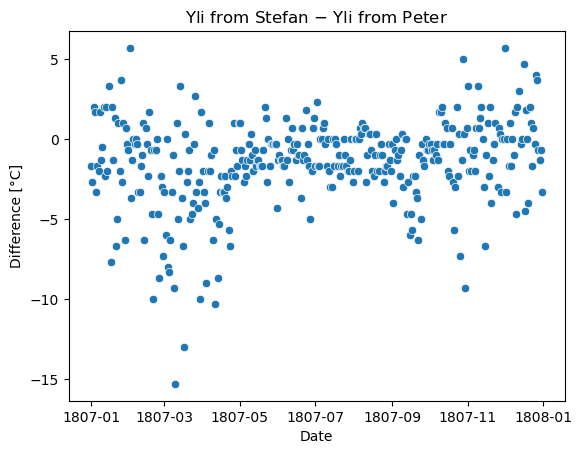

In [6]:
yli_usb = pd.read_csv('/home/ccorbella/scratch2_symboliclink/files/1807_USBstick/Ylitornio_ta_daily.tsv',
                      skiprows=12, delimiter='\t')

make_date_col(yli_usb)
yli_1807 = yli[yli['Date']>='1807-01-01']
yli_1807 = yli_1807[yli_1807['Date']<='1807-12-31']
yli_usb['Value'] = pd.to_numeric(yli_usb['Value'])
yli_1807['TMP2m'] = pd.to_numeric(yli_1807['TMP2m'], errors='coerce')

diff = (yli_1807['TMP2m'].astype(float).reset_index(drop=True) - 
        yli_usb['Value'].astype(float).reset_index(drop=True))

yli_plot = sns.scatterplot(x=yli_1807['Date'].reset_index(drop=True), y=diff)
yli_plot.set_title(r'Yli from Stefan $-$ Yli from Peter')
yli_plot.set_ylabel('Difference [°C]')
fig = yli_plot.get_figure()
fig.savefig('Yli_diff.png')

Let's look at the correlation, because this is very strange.

0.9816269662419703 4.4462635174699685e-261


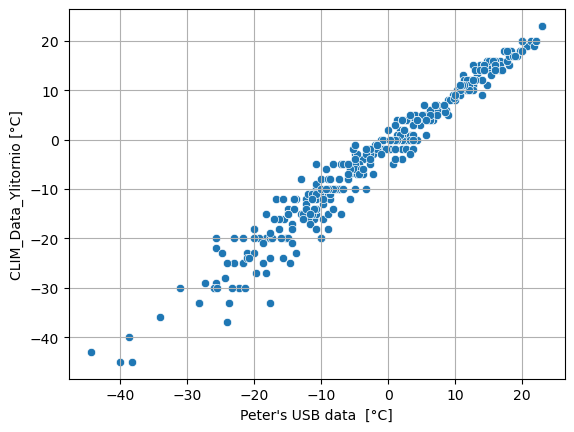

In [38]:
from scipy.stats import pearsonr
yli_usb_ta = yli_usb['Value'].to_numpy()
yli_1807_ta = yli_1807['TMP2m'].to_numpy()
mask = ~np.isnan(yli_usb_ta) & ~np.isnan(yli_1807_ta)

pr, pval = pearsonr(yli_usb_ta[mask],yli_1807_ta[mask])
print(pr, pval)


pl = sns.scatterplot(x=yli_usb_ta[mask], y=yli_1807_ta[mask])
pl.set_xlabel('Peter\'s USB data  [°C]')
pl.set_ylabel('CLIM_Data_Ylitornio [°C]')
pl.grid(True)

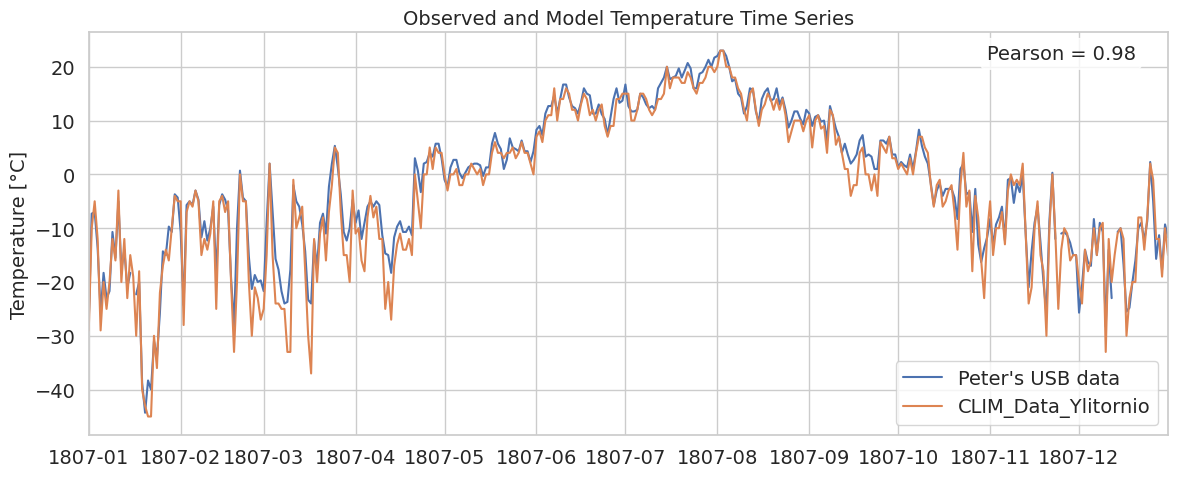

In [74]:

plt.figure(figsize=(12, 5))
ax=plt.gca()
plt.plot(yli_usb['Date'], yli_usb['Value'], label='Peter\'s USB data')
plt.plot(yli_1807['Date'], yli_1807['TMP2m'], label='CLIM_Data_Ylitornio')
plt.ylabel('Temperature [°C]')
plt.title('Observed and Model Temperature Time Series')
plt.legend()

ax.set_xmargin(0)

# Add Pearson r text box
textstr = f"Pearson = {pr:.2f}"
ax.text(0.97, 0.97, textstr,
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add legend bottom right
ax.legend(loc='lower right')

plt.grid(True)
plt.tight_layout()
plt.show()


## Zwanenburg

In [72]:
df = pd.read_csv(f'{file_readdir}DeBilt_1_17430101-18501231_mslp.tsv', sep='\t', header=12)
make_date_col(df)
df = select_dates(df)

df = df.groupby('Date').agg(PRMSL=('Value', 'mean')).reset_index()
df.to_csv(f'{file_savedir}Zwanenburg_PRMSL.csv')